In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# plotly is an advanced visualization tool
import plotly as py
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
import plotly.graph_objs as go
import warnings
warnings.filterwarnings("ignore")

In [4]:
df = pd.read_csv(r'C:\Users\91783\Desktop\Results\YJ_Mean_Date_PM2.csv')
df.head()
df['Date'] = pd.to_datetime(df['Date'])
df.head()

,Date,PM2.5
0,2021-01-01,1.575013
1,2021-02-01,1.127264
2,2021-03-01,0.042478
3,2021-04-01,-0.261624
4,2021-05-01,0.116524


In [5]:
df = df.set_index('Date').asfreq('D')

In [6]:
df.columns = ['PM2.5']

In [8]:
print(f'The Daily data consists of values from {df.index.min()} to {df.index.max()}')

The Daily data consists of values from 2021-01-01 00:00:00 to 2021-12-31 00:00:00


In [40]:
# Finding the split point index to keep 1 month (30 days) data as test set
n_test = 1
train_data = df.iloc[:len(df) - n_test]
test_data = df.iloc[len(df) - n_test:]

In [41]:
train_data['PM2.5']

Date
2021-01-01    1.575013
2021-01-02    1.425261
2021-01-03    0.862368
2021-01-04    0.306817
2021-01-05    0.104472
                ...   
2021-12-26    1.525707
2021-12-27    0.568008
2021-12-28    0.672111
2021-12-29    0.424150
2021-12-30    0.502374
Freq: D, Name: PM2.5, Length: 364, dtype: float64

In [42]:
from arch import arch_model
am = arch_model(train_data['PM2.5'], vol='Garch', p=1, o=0, q=1, dist='Normal')

In [43]:
res = am.fit(disp='off')
display(res.summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                  PM2.5   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -366.663
Distribution:                  Normal   AIC:                           741.327
Method:            Maximum Likelihood   BIC:                           756.915
                                        No. Observations:                  364
Date:                Thu, Jun 16 2022   Df Residuals:                      363
Time:                        17:26:09   Df Model:                            1
                                Mean Model                                
==========================================================================
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu            -0.1275      0.105     -1.212      0.226 [ -0.334,7.872e-02]
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega          0.0405  1.114e-02      3.638  2.750e-04 [1.870e-02,6.238e-02]
alpha[1]       0.8087  7.704e-02     10.497  8.928e-26     [  0.658,  0.960]
beta[1]        0.1891  7.879e-02      2.399  1.642e-02   [3.463e-02,  0.343]
============================================================================

Covariance estimator: robust
"""

In [44]:
df['forecast_vol'] = 0.1 * np.sqrt(res.params['omega'] + res.params['alpha[1]'] * res.resid**2 + 
                                   res.conditional_volatility**2 * res.params['beta[1]'])

In [45]:
df

,PM2.5,forecast_vol
Date,,
2021-01-01,1.575013,0.159807
2021-01-02,1.425261,0.157265
2021-01-03,0.862368,0.114041
2021-01-04,0.306817,0.066255
2021-01-05,0.104472,0.040873
...,...,...
2021-12-27,0.568008,0.097731
2021-12-28,0.672111,0.085919
2021-12-29,0.424150,0.065286


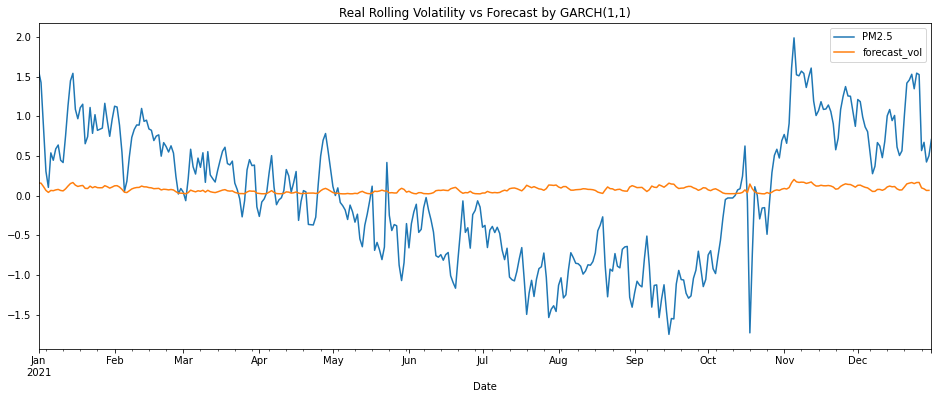

In [46]:
plt.figure(figsize=(16,6))
df["PM2.5"].plot()
df["forecast_vol"].plot()
plt.title("Real Rolling Volatility vs Forecast by GARCH(1,1)")
plt.legend()
plt.show()

In [48]:

def rmse_tr(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())
skor = rmse_tr(df.loc[df.index[1000:], 'forecast_vol'], df.loc[df.index[1000:], 'PM2.5'])
print("Root Mean Squared Error of the model is calculated as ",skor)

Root Mean Squared Error of the model is calculated as  nan
